Cell 1 — Setup & Imports

In [1]:
# Cell 1 - Setup & imports 
%matplotlib inline
import os
import copy
import time
from glob import glob
import platform
import random

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader as PyGDataLoader
from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, matthews_corrcoef,
    precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
)
from tqdm import tqdm
import matplotlib.pyplot as plt

# Project imports 
from GraphDataset import make_graph_dataloaders, count_graphs_in_split, GraphFolderDataset
from model_GINE import GINEModel

# Print versions / device
print("torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True  


torch: 2.5.1+cu121
Device: cuda


Cell 2 — Small utility functions (metrics, save/load)

In [2]:
# Cell 2 - utilities 
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def compute_classification_metrics(y_true, probs, threshold=0.5):
    y_true = np.asarray(y_true).astype(int)
    probs = np.asarray(probs).astype(float)
    preds = (probs >= threshold).astype(int)

    def safe(f, *args, **kwargs):
        try:
            return float(f(*args, **kwargs))
        except Exception:
            return float("nan")

    metrics = {
        "ROC_AUC": safe(roc_auc_score, y_true, probs),
        "Accuracy": safe(accuracy_score, y_true, preds),
        "BA": safe(balanced_accuracy_score, y_true, preds),
        "MCC": safe(matthews_corrcoef, y_true, preds),
        "PRE": safe(precision_score, y_true, preds, zero_division=0),
        "REC": safe(recall_score, y_true, preds, zero_division=0),
        "F1":  safe(f1_score, y_true, preds, zero_division=0),
        "Confusion": None
    }
    # compute confusion safely
    try:
        metrics["Confusion"] = confusion_matrix(y_true, preds)
    except Exception:
        metrics["Confusion"] = None

    return metrics

def print_metrics_table(name, metrics):
    print(f"--- {name} ---")
    print(f"ROC_AUC: {metrics['ROC_AUC']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f} | BA: {metrics['BA']:.4f} | MCC: {metrics['MCC']:.4f}")
    print(f"PRE: {metrics['PRE']:.4f} | REC: {metrics['REC']:.4f} | F1: {metrics['F1']:.4f}")
    print("Confusion matrix:\n", metrics['Confusion'])
    print()


Cell 3 — Parameters / Paths

In [3]:
# Cell 3 - Parameters 
ISOFORM = "2C19"
GRAPH_ROOT = "../GraphDataset"   # root where <ISOFORM>/train val test folders live
MODEL_OUT_DIR = "models"
os.makedirs(MODEL_OUT_DIR, exist_ok=True)

# Hyperparameters
PARAMS = {
    "batch_size": 100,        
    "learning_rate": 0.001 ,
    "weight_decay": 1e-4,
    "epochs": 50,            
    "patience": 5,            # early stopping patience (validation)
    #"pos_weight": 1.3,             # if you want weighted BCE for imbalance, else set None
    "model_embedding_size": 128,
    "model_layers": 4,
    "model_dropout_rate": 0.2,
}

TRAIN_FOLDER = os.path.join(GRAPH_ROOT, ISOFORM, "train")
VAL_FOLDER   = os.path.join(GRAPH_ROOT, ISOFORM, "val")
TEST_FOLDER  = os.path.join(GRAPH_ROOT, ISOFORM, "test")

print("Train folder:", TRAIN_FOLDER)
print("Val folder:  ", VAL_FOLDER)
print("Test folder: ", TEST_FOLDER)

# quick sanity counts (uses your helper)
try:
    counts = count_graphs_in_split(ISOFORM, root=GRAPH_ROOT)
    print("Graph counts:", counts)
except Exception as e:
    print("Couldn't count graphs with helper (maybe path differs):", e)


Train folder: ../GraphDataset\2C19\train
Val folder:   ../GraphDataset\2C19\val
Test folder:  ../GraphDataset\2C19\test
Graph counts: {'train': 10132, 'val': 1266, 'test': 1267}


Cell 4 — Dataset / DataLoader helper (uses your GraphFolderDataset)

In [4]:
# Cell 4 - Data loader factory 
import sys
IS_WINDOWS = platform.system().lower().startswith("win")

def make_graph_loaders(train_folder, val_folder, test_folder, batch_size,
                       num_workers=None, pin_memory=None, preload=False):
    # choose safe num_workers and pin_memory depending on platform and device
    if num_workers is None:
        num_workers = 0 if IS_WINDOWS else min(4, max(0, (os.cpu_count() or 1)//2))
    if pin_memory is None:
        pin_memory = True if (device.type == "cuda") else False

    train_ds = GraphFolderDataset(train_folder, preload=preload)
    val_ds = GraphFolderDataset(val_folder, preload=preload) if os.path.isdir(val_folder) else None
    test_ds = GraphFolderDataset(test_folder, preload=preload) if os.path.isdir(test_folder) else None

    train_loader = PyGDataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                 num_workers=num_workers, pin_memory=pin_memory)
    val_loader = PyGDataLoader(val_ds, batch_size=batch_size, shuffle=False,
                               num_workers=max(0, num_workers//2), pin_memory=pin_memory) if val_ds is not None else None
    test_loader = PyGDataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                num_workers=max(0, num_workers//2), pin_memory=pin_memory) if test_ds is not None else None

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_graph_loaders(TRAIN_FOLDER, VAL_FOLDER, TEST_FOLDER, PARAMS["batch_size"])
print("Batches -> train:", len(train_loader), " val:", len(val_loader) if val_loader else 0, " test:", len(test_loader) if test_loader else 0)


Batches -> train: 102  val: 13  test: 13


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Cell 5 — Training / evaluation helpers

In [5]:
# Cell 5 - training/eval helpers (edge-aware for GINE)
def train_one_epoch_gnn(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    n_steps = 0
    for batch in loader:
        batch = batch.to(device)

        # Prepare tensors with safe dtypes
        x = batch.x.float()
        edge_index = batch.edge_index.long()
        edge_attr = batch.edge_attr.float() if hasattr(batch, "edge_attr") else None
        batch_idx = batch.batch if hasattr(batch, "batch") else x.new_zeros(x.size(0), dtype=torch.long)

        optimizer.zero_grad()
        # NOTE: order = (x, edge_index, edge_attr, batch)
        out = model(x, edge_index, edge_attr, batch_idx)
        if out.dim() > 1 and out.shape[1] == 1:
            out = out.view(-1)
        loss = loss_fn(out, batch.y.float().view(-1).to(device))
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item())
        n_steps += 1
    return running_loss / max(1, n_steps)


def eval_model_gnn(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)

            x = batch.x.float()
            edge_index = batch.edge_index.long()
            edge_attr = batch.edge_attr.float() if hasattr(batch, "edge_attr") else None
            batch_idx = batch.batch if hasattr(batch, "batch") else x.new_zeros(x.size(0), dtype=torch.long)

            out = model(x, edge_index, edge_attr, batch_idx)
            if out.dim() > 1 and out.shape[1] == 1:
                out = out.view(-1)
            probs = torch.sigmoid(out).detach().cpu().numpy()
            all_probs.extend(probs.tolist())
            all_labels.extend(batch.y.cpu().numpy().astype(int).tolist())

    return np.array(all_labels), np.array(all_probs)


Cell 6 — Instantiate model, optimizer, loss (using PARAMS)

# GINEModel

In [6]:
# Cell 6 - instantiate model & optimizer (for GINE)
# Inspect a sample to get node & edge feature dims
sample = next(iter(train_loader))
in_node_feats = sample.x.shape[1]
in_edge_feats = sample.edge_attr.shape[1] if hasattr(sample, "edge_attr") else None
print("Node feature dim:", in_node_feats, "Edge feature dim:", in_edge_feats)

model_params = {
    "model_embedding_size": PARAMS["model_embedding_size"],
    "model_layers": PARAMS["model_layers"],
    "model_dropout_rate": PARAMS["model_dropout_rate"],
    "model_dense_neurons": 256,
    "use_bn": True
}

# NOTE: GINEModel constructor expects (in_node_feats, in_edge_feats, model_params)
model = GINEModel(in_node_feats, in_edge_feats, model_params).to(device)

# Optionally use pos_weight for imbalanced training
if PARAMS.get("pos_weight") is not None:
    pos_w = torch.tensor([PARAMS["pos_weight"]], dtype=torch.float32).to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_w)
else:
    loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=PARAMS["learning_rate"], weight_decay=PARAMS["weight_decay"])

print("Number of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Node feature dim: 94 Edge feature dim: 42
Number of trainable parameters: 249601


Cell 7 — Training loop with early stopping & saving best model

In [7]:
# Cell 7 - train loop with early stopping 
epochs = PARAMS["epochs"]
patience = PARAMS["patience"]
best_val_auc = -1.0
best_state = None
no_improve = 0

start_time = time.time()
for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch_gnn(model, train_loader, optimizer, loss_fn, device)
    if val_loader is not None:
        y_val, p_val = eval_model_gnn(model, val_loader, device)
        val_metrics = compute_classification_metrics(y_val, p_val)
        val_auc = val_metrics["ROC_AUC"] if not np.isnan(val_metrics["ROC_AUC"]) else -1.0
    else:
        val_auc = -1.0
        val_metrics = {}

    elapsed = time.time() - start_time
    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_auc={val_auc:.4f} | elapsed={elapsed/60:.2f} min")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = copy.deepcopy(model.state_dict())
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping: no improvement for", patience, "epochs")
            break

# Save best model
if best_state is None:
    print("Warning: no best model found (no val set?). Saving final state.")
    best_state = model.state_dict()

model_save_path = os.path.join(MODEL_OUT_DIR, f"GINE_CYP{ISOFORM}.pth")
torch.save(best_state, model_save_path)
print("Saved model to", model_save_path)


Epoch 001 | train_loss=0.6439 | val_auc=0.7837 | elapsed=0.31 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 002 | train_loss=0.5642 | val_auc=0.8089 | elapsed=0.47 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 003 | train_loss=0.5157 | val_auc=0.8344 | elapsed=0.62 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 004 | train_loss=0.4926 | val_auc=0.8207 | elapsed=0.78 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 005 | train_loss=0.4763 | val_auc=0.8272 | elapsed=0.93 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 006 | train_loss=0.4722 | val_auc=0.8303 | elapsed=1.09 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 007 | train_loss=0.4584 | val_auc=0.8508 | elapsed=1.24 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 008 | train_loss=0.4489 | val_auc=0.8119 | elapsed=1.40 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 009 | train_loss=0.4452 | val_auc=0.8608 | elapsed=1.53 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 010 | train_loss=0.4379 | val_auc=0.8493 | elapsed=1.67 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 011 | train_loss=0.4360 | val_auc=0.8289 | elapsed=1.83 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 012 | train_loss=0.4268 | val_auc=0.8588 | elapsed=1.98 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 013 | train_loss=0.4256 | val_auc=0.8672 | elapsed=2.14 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 014 | train_loss=0.4132 | val_auc=0.8373 | elapsed=2.30 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 015 | train_loss=0.4162 | val_auc=0.8428 | elapsed=2.45 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 016 | train_loss=0.4113 | val_auc=0.8442 | elapsed=2.61 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 017 | train_loss=0.4050 | val_auc=0.8493 | elapsed=2.76 min


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

Epoch 018 | train_loss=0.4083 | val_auc=0.8560 | elapsed=2.91 min
Early stopping: no improvement for 5 epochs
Saved model to models\GINE_CYP2C19.pth


Cell 8 — Final evaluation on train / val / test (print metrics)

In [8]:
# Cell 8 - final evaluation (edge-aware)
model.load_state_dict(best_state)
model.to(device)

for name, loader in [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]:
    if loader is None:
        print(f"{name}: no loader (skipping)")
        continue
    y_true, probs = eval_model_gnn(model, loader, device)
    metrics = compute_classification_metrics(y_true, probs)
    print_metrics_table(name, metrics)


e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

--- Train ---
ROC_AUC: 0.9032
Accuracy: 0.8251 | BA: 0.8269 | MCC: 0.6510
PRE: 0.7850 | REC: 0.8456 | F1: 0.8142
Confusion matrix:
 [[4478 1063]
 [ 709 3882]]



e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

--- Val ---
ROC_AUC: 0.8672
Accuracy: 0.7954 | BA: 0.7945 | MCC: 0.5914
PRE: 0.7807 | REC: 0.8349 | F1: 0.8069
Confusion matrix:
 [[466 152]
 [107 541]]



e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

--- Test ---
ROC_AUC: 0.8628
Accuracy: 0.7837 | BA: 0.7868 | MCC: 0.5716
PRE: 0.7361 | REC: 0.8224 | F1: 0.7769
Confusion matrix:
 [[516 171]
 [103 477]]



Cell 9 — Optional: Confusion matrix heatmap for test

e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = t

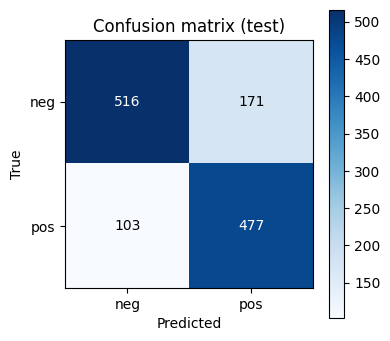

In [9]:
if test_loader is not None:
    y_true, probs = eval_model_gnn(model, test_loader, device)  # no edge_attr
    metrics = compute_classification_metrics(y_true, probs)
    cm = metrics["Confusion"]

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix (test)")
    plt.colorbar()

    ticklabels = ["neg", "pos"]
    plt.xticks([0, 1], ticklabels)
    plt.yticks([0, 1], ticklabels)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.show()


# GNNExplainer

In [10]:
# Cell 1 — Imports, config, device
%matplotlib inline
import os, glob, math
from pathlib import Path
from typing import List, Optional, Dict, Tuple

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# PyG explain API
from torch_geometric.explain import Explainer, Explanation
from torch_geometric.explain.algorithm import GNNExplainer
from torch_geometric.explain.config import ModelConfig

# RDKit for molecule visualization
from rdkit import Chem
from rdkit.Chem.Draw import MolsToImage, rdMolDraw2D
from rdkit.Chem import Draw



from model_GINE import GINEModel as GraphModelClass


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [11]:
# Cell 2 — Paths & helper functions
ISOFORM = "2C19"
GRAPH_ROOT = os.path.join("..", "GraphDataset", ISOFORM, "test")   # folder with .pt test graphs
CSV_TEST    = os.path.join("..", "data", "processed", f"{ISOFORM}_test.csv")  # optional SMILES mapping
MODEL_PATH  = f"models/GINE_CYP{ISOFORM}.pth"  
# fallbacks: try other names if file not found
if not os.path.exists(MODEL_PATH):
    alt = f"models/GIN_CYP{ISOFORM}.pth"
    if os.path.exists(alt):
        MODEL_PATH = alt

assert os.path.isdir(GRAPH_ROOT), f"Graph folder not found: {GRAPH_ROOT}"
assert os.path.exists(MODEL_PATH), f"Model file not found: {MODEL_PATH}"
if not os.path.exists(CSV_TEST):
    print(f"Warning: CSV mapping {CSV_TEST} not found. Atom-level SMILES visualization will be limited.")

# helper: load Data object path -> Data
def load_graph_pt(pt_path):
    return torch.load(pt_path)

# helper to extract numeric drug id from filename "12345_1.pt" -> "12345"
def drug_id_from_filename(fname: str) -> str:
    name = Path(fname).stem  # "1001112_1"
    return name.split("_")[0]

# helper: RDKit molecule from SMILES (if you have CSV mapping)
def mol_from_smiles(smiles: str):
    return Chem.MolFromSmiles(smiles)

# helper: normalize mask to [0,1]
def normalize_mask(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return x
    mn, mx = x.min(), x.max()
    if math.isclose(mx, mn):
        return np.zeros_like(x)
    return (x - mn) / (mx - mn)


In [12]:
# Cell 3 — List available test graphs and select a few
pt_files = sorted(glob.glob(os.path.join(GRAPH_ROOT, "*.pt")))
print(f"Found {len(pt_files)} .pt files in {GRAPH_ROOT}")

K = 10
sel_files = pt_files[:K]
for i, p in enumerate(sel_files):
    print(i, os.path.basename(p))


Found 1267 .pt files in ..\GraphDataset\2C19\test
0 1001459_1.pt
1 1005734_0.pt
2 1008368_1.pt
3 1010280_0.pt
4 1012180_1.pt
5 1012499_1.pt
6 1017322_1.pt
7 1019208_1.pt
8 1025927_1.pt
9 104999_0.pt


In [13]:
# Cell 4 — Load the model  and prepare Explainer

# Inspect first selected graph to know node/edge dims
sample = load_graph_pt(sel_files[0])
in_node_feats = sample.x.shape[1]
in_edge_feats = sample.edge_attr.shape[1] if hasattr(sample, "edge_attr") and sample.edge_attr is not None else None
print("Sample dims -> node_feats:", in_node_feats, "edge_feats:", in_edge_feats)

# Build model_params consistent with how model was trained (update keys as needed)
model_params = {
    "model_embedding_size": 128,
    "model_layers": 4,
    "model_dropout_rate": 0.2,
    "model_dense_neurons": 256,
    # For GINEModel ensure in_edge_feats was used during training
}

# Instantiate model depending on class signature:
# - GINEModel(in_node_feats, in_edge_feats, model_params)
# - GINModel(in_feats, model_params)
try:
    # try GINE constructor style
    model = GraphModelClass(in_node_feats, in_edge_feats, model_params)
    print("Constructed model with (in_node_feats, in_edge_feats, model_params) signature.")
except TypeError:
    # fallback to older GIN signature
    model = GraphModelClass(in_node_feats, model_params)
    print("Constructed model with (in_feats, model_params) signature.")

# Load checkpoint (be tolerant to state_dict or full checkpoint)
ckpt = torch.load(MODEL_PATH, map_location="cpu")
if isinstance(ckpt, dict) and ("model" in ckpt or any(k.startswith("module.") for k in ckpt.keys())):
    # either it's a wrapped dict or a state_dict
    if "model" in ckpt:
        state = ckpt["model"]
    else:
        state = ckpt
    model.load_state_dict(state, strict=False)
else:
    # assume it's a plain state_dict
    try:
        model.load_state_dict(ckpt, strict=False)
    except Exception:
        # last resort: try if ckpt is full model (rare)
        print("Warning: couldn't load checkpoint as state_dict, trying to load directly (may fail).")
        model = ckpt

model = model.to(device)
model.eval()
print("Model loaded. Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Explainer configuration:
algorithm = GNNExplainer(epochs=100, lr=0.01)  # epochs can be increased for better explanations
model_conf = ModelConfig(mode='binary_classification', task_level='graph', return_type='raw')
explainer = Explainer(
    model=model,
    algorithm=algorithm,
    explanation_type='model',   # explain model prediction
    model_config=model_conf,
    node_mask_type='object',    # mask each node
    edge_mask_type='object'     # mask each edge
)
print("Explainer constructed.")


Sample dims -> node_feats: 94 edge_feats: 42
Constructed model with (in_node_feats, in_edge_feats, model_params) signature.
Model loaded. Trainable params: 249601
Explainer constructed.


C:\Users\Afra\AppData\Local\Temp\ipykernel_12436\1538734583.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(pt_path)
C:\Users\Afra\AppData\Local\Temp\